In [1]:
%reload_ext autoreload
%autoreload 2
%load_ext watermark
%watermark -a 'Marcos Santana' -d -p sklearn,rdkit,matplotlib,seaborn,optuna,numpy,pandas,joblib,mols2grid -v

Author: Marcos Santana

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.19.0

sklearn   : 0.23.2
rdkit     : 2021.03.4
matplotlib: 3.3.3
seaborn   : 0.11.1
optuna    : 2.9.1
numpy     : 1.19.4
pandas    : 1.1.4
joblib    : 0.17.0
mols2grid : not installed



In [27]:
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd
import numpy as np

from pathlib import Path
from joblib import load, dump
from rdkit.Chem import MolToSmiles, MolFromSmiles, AllChem

from rdkit.Chem.Descriptors import MolWt, MolLogP, NumHDonors, NumHAcceptors

from utils.featurizer import *

In [4]:
sns.set_context('paper', font_scale=1.5)
sns.set_style('whitegrid')

In [5]:
data_names = ['203','2959','2073','4722','4630','4282']

target_name = ['Epidermal growth factor receptor',
 'Tyrosine-protein kinase ITK/TSK',
 'Tyrosine-protein kinase YES',
               
'Serine/threonine-protein kinase Aurora-A',
 'Serine/threonine-protein kinase Chk1',
 'Serine/threonine-protein kinase AKT'
]
target_codes = list(zip(target_name, data_names))

In [6]:
target_codes

[('Epidermal growth factor receptor', '203'),
 ('Tyrosine-protein kinase ITK/TSK', '2959'),
 ('Tyrosine-protein kinase YES', '2073'),
 ('Serine/threonine-protein kinase Aurora-A', '4722'),
 ('Serine/threonine-protein kinase Chk1', '4630'),
 ('Serine/threonine-protein kinase AKT', '4282')]

In [7]:
chembl = pd.read_csv(f'../storage/data/chembl/chembl27_2021-02-21.csv.gz')

/opt/conda/envs/fastai/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
dfs = []
for target in data_names:
    dataset = pd.read_csv(f'data/FCFP/data_CHEMBL{target}_SMILES_FCFP_nodupli.csv')
    dataset['Target'] = f'CHEMBL{target}'
    dfs.append(dataset)

In [9]:
dfs = pd.concat(dfs,axis=0)

In [13]:
subset_chembl = chembl[chembl['target_chembl_id'].isin([f'CHEMBL{t}' for t in data_names])]

In [14]:
dfs['MW'] = dfs['processed_smiles'].apply(lambda x : MolWt(MolFromSmiles(x)))
dfs['logP'] = dfs['processed_smiles'].apply(lambda x : MolLogP(MolFromSmiles(x)))
dfs['HBD'] = dfs['processed_smiles'].apply(lambda x : NumHDonors(MolFromSmiles(x)))
dfs['HBA'] = dfs['processed_smiles'].apply(lambda x : NumHAcceptors(MolFromSmiles(x)))

In [15]:
dfs.head()

,molecule_id_corrected,processed_smiles,pXC50,b0001,b0002,b0003,b0004,b0005,b0006,b0007,...,b1020,b1021,b1022,b1023,b1024,Target,MW,logP,HBD,HBA
0,CHEMBL10,C[S+](O)c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)[...,5.7700,1,0,0,1,1,1,1,...,0,1,0,0,0,CHEMBL203,378.452,5.0248,2,3
1,CHEMBL100714,COc1ccc(Nc2ncnc3cc(OC)c(OC)cc23)cc1OC,6.0045,1,0,1,0,1,0,1,...,0,0,0,0,0,CHEMBL203,341.367,3.4078,1,7
2,CHEMBL1009,N[C@@H](Cc1ccc(O)c(O)c1)C(=O)O,5.5410,1,1,1,1,1,0,0,...,0,0,0,0,0,CHEMBL203,197.190,0.0522,4,4
3,CHEMBL101253,Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1,5.0000,1,0,0,0,1,0,1,...,0,0,0,0,0,CHEMBL203,346.821,5.0126,1,4
4,CHEMBL101581,COc1cc2nccc(Oc3cccc(Br)c3)c2cc1OC,5.6020,1,0,1,0,1,0,1,...,0,0,0,0,0,CHEMBL203,360.207,4.8068,0,4


In [16]:
dfs.groupby('Target')[['pXC50','MW']].describe().T

Target         CHEMBL203  CHEMBL2073   CHEMBL2959   CHEMBL4282   CHEMBL4630  \
pXC50 count  4960.000000  134.000000  1235.000000  2226.000000  2702.000000   
      mean      5.994812    6.228560     6.015619     5.965387     6.190954   
      std       1.320059    1.396964     0.877289     1.257615     1.388196   
      min       4.000000    4.025000     4.000000     4.000000     4.000000   
      25%       5.000000    5.000000     5.781500     5.100000     5.100000   
      50%       5.700000    5.906500     5.800000     5.462500     5.700000   
      75%       6.959000    7.523000     6.456000     6.840500     7.354500   
      max      11.000000    9.523000     9.523000     9.796000    10.523000   
MW    count  4960.000000  134.000000  1235.000000  2226.000000  2702.000000   
      mean    406.126492  449.786082   413.743417   430.439462   382.629970   
      std     112.094003   78.031181    93.055405   127.218523    81.808076   
      min     110.112000  255.325000   156.188000   148.169000   148.169000   
      25%     333.459000  380.764250   346.331000   356.429000   332.359000   
      50%     398.260000  456.074000   411.465000   414.489000   381.413500   
      75%     467.570000  509.406750   483.597500   481.549750   435.310750   
      max    3688.829000  641.621000   708.796000  1115.397000   788.612000   

Target        CHEMBL4722  
pXC50 count  2606.000000  
      mean      6.268748  
      std       1.188821  
      min       1.395000  
      25%       5.400000  
      50%       6.000000  
      75%       7.185250  
      max      10.000000  
MW    count  2606.000000  
      mean    415.624284  
      std     111.429453  
      min     151.194000  
      25%     347.378000  
      50%     410.481000  
      75%     477.275000  
      max    1412.710000

# Analysis

## Boxplot

In [17]:
melted_dataset = pd.melt(dfs,id_vars='Target',value_vars=['HBD','HBA','logP'])
melted_dataset

,Target,variable,value
0,CHEMBL203,HBD,2.00000
1,CHEMBL203,HBD,1.00000
2,CHEMBL203,HBD,4.00000
3,CHEMBL203,HBD,1.00000
4,CHEMBL203,HBD,0.00000
...,...,...,...
41584,CHEMBL4282,logP,2.50740
41585,CHEMBL4282,logP,3.51370
41586,CHEMBL4282,logP,4.27560
41587,CHEMBL4282,logP,4.59032


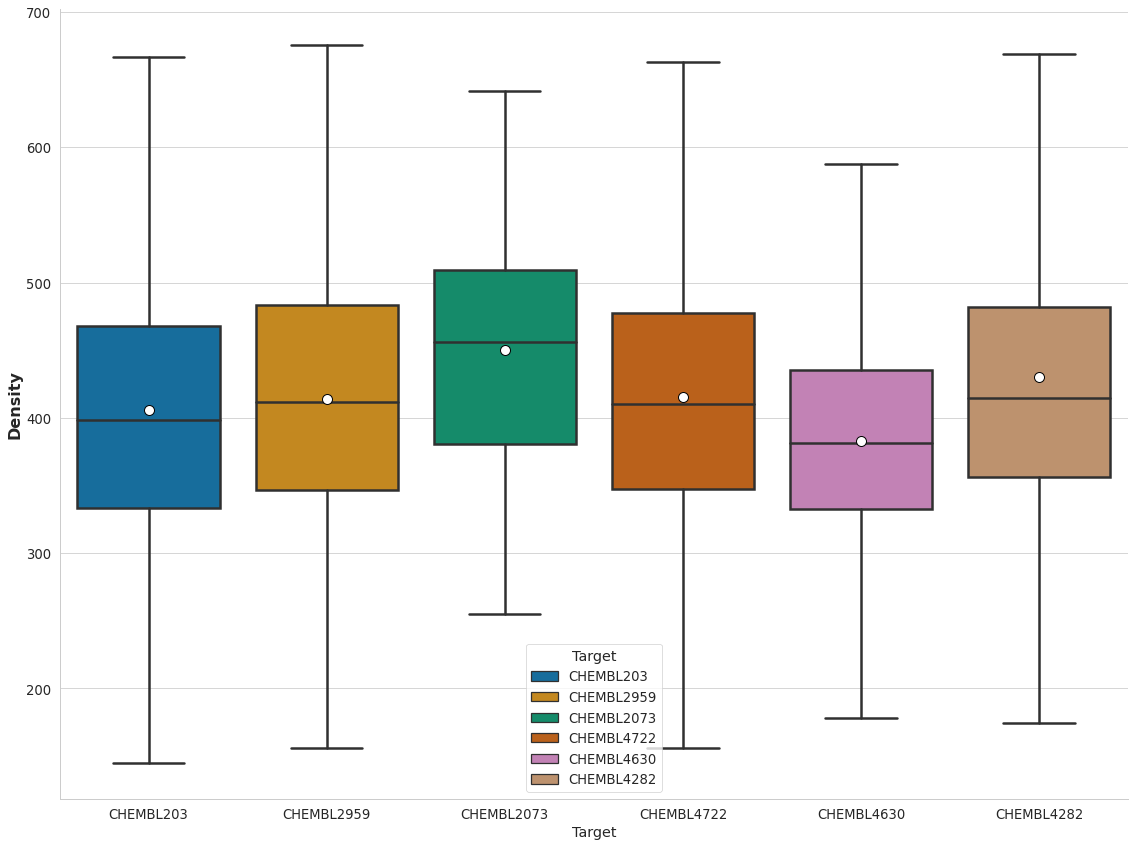

In [18]:
plt.figure(figsize=(16,12))
plt.rc('axes',edgecolor='black')  
sns.set_context('paper', font_scale=1.5)
sns.set_style('whitegrid')

#t = 'HBA'
ax=sns.boxplot(x='Target',y='MW',data=dfs,hue='Target',
               showmeans=True,meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
               notch=False,linewidth=2.5,palette='colorblind',dodge=False,showfliers=False)
#ax.get_legend().remove()
#ax.set_title(f'CHEMBL{target}',fontweight='bold')
#ax.set_xlabel(t,fontsize=16,fontweight='bold')
ax.set_ylabel('Density',fontsize=16,fontweight='bold')
  
sns.despine(right=True, top=True)
plt.tight_layout()
#plt.savefig(f'Analysis/boxplot_{t}_data.png',dpi=600)

## KDE plot

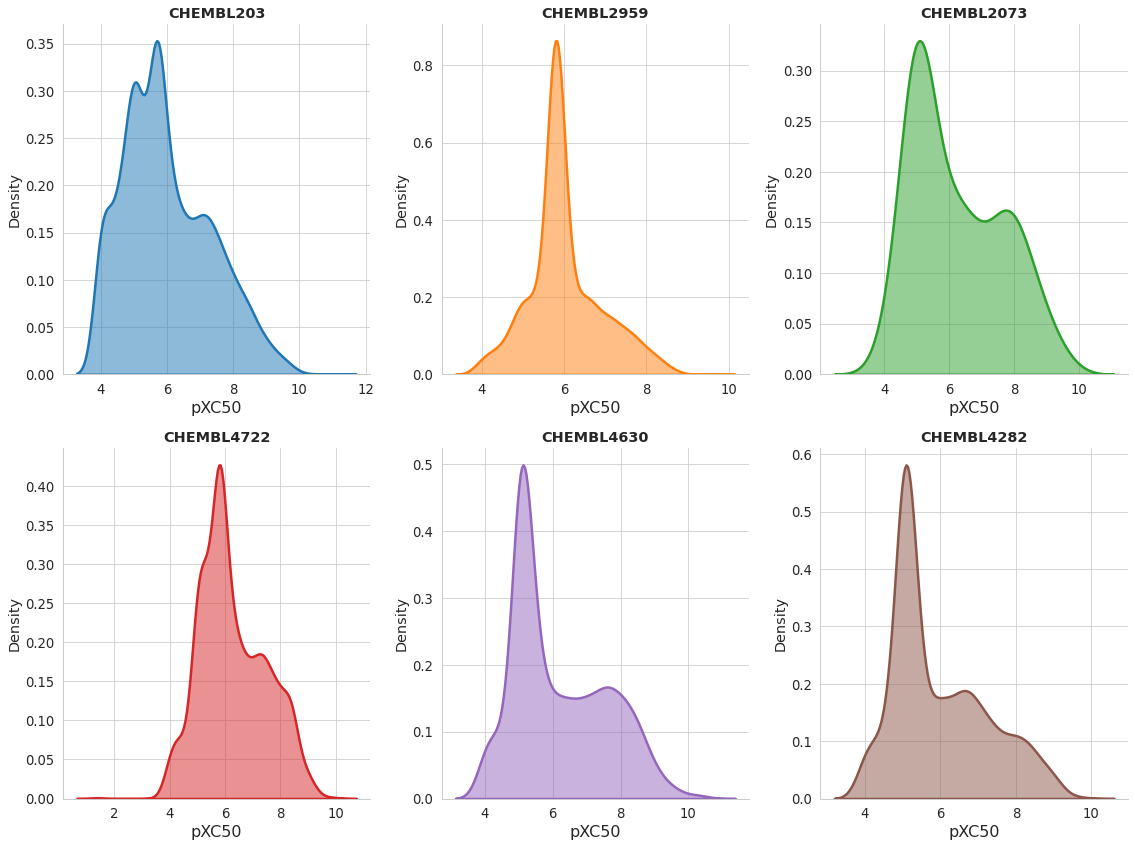

In [19]:
fig, ax = plt.subplots(2,3,figsize=(16,12))

fig.subplots_adjust(left=0.15,bottom=0.05)

sns.set_context('paper', font_scale=1.5)
sns.set_style('whitegrid')
ax = ax.ravel()
cmap = plt.get_cmap('tab10').colors
for i,target in enumerate(data_names):
    sns.kdeplot(x='pXC50',data=dfs[dfs['Target']==f'CHEMBL{target}']
                ,ax=ax[i],shade=True,
                alpha=0.5,linewidth=2.5,color=cmap[i])
    
    
    ax[i].set_title(f'CHEMBL{target}',fontweight='bold')
    ax[i].set_xlabel('pXC50',fontsize=16)

    
sns.despine(right=True, top=True)
plt.tight_layout()
#plt.savefig('Analysis/kdeplot_data.png',dpi=600)

# Chemical space

In [20]:
from utils.featurizer import *
import umap

## Overlap between chemical spaces

In [21]:
targ_matrix = np.zeros((len(target_codes), len(target_codes)))

In [22]:
targ_matrix

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [23]:
for t1, (targ1_name, target1) in enumerate(target_codes):
    for t2, (targ2_name, target2) in enumerate(target_codes):
        #if target1 != target2:
        sub1 = dfs[dfs['Target']==f'CHEMBL{target1}']
        sub2 = dfs[dfs['Target']==f'CHEMBL{target2}']
        overlap = set.intersection(set(sub1.processed_smiles),set(sub2.processed_smiles))
            
        targ_matrix[t1, t2] = len(overlap)/len(sub1)
           #print(f'{targ1_name} / {targ2_name} -> Overlap = {100*len(overlap)/len(sub1):.3f}%')
            #print()

In [24]:
targ_overlap_df = pd.DataFrame(targ_matrix, columns=[f'CHEMBL{d}' for d in data_names], index=[f'CHEMBL{d}' for d in data_names])

In [25]:
targ_overlap_df

,CHEMBL203,CHEMBL2959,CHEMBL2073,CHEMBL4722,CHEMBL4630,CHEMBL4282
CHEMBL203,1.000000,0.130645,0.018750,0.153427,0.148589,0.147782
CHEMBL2959,0.524696,1.000000,0.063968,0.513360,0.532794,0.530364
CHEMBL2073,0.694030,0.589552,1.000000,0.664179,0.582090,0.634328
CHEMBL4722,0.292018,0.243285,0.034152,1.000000,0.343054,0.288565
CHEMBL4630,0.272761,0.243523,0.028868,0.330866,1.000000,0.314952
CHEMBL4282,0.329290,0.294250,0.038185,0.337826,0.382300,1.000000


In [154]:
targ_overlap_df.to_csv('Analysis/Bioactivity_overlap.csv')

## Similarity matrix

In [36]:
from rdkit.Chem import DataStructs
from rdkit import Chem

In [30]:
features = [x for x in dfs.columns if x.startswith('b')]
len(features),features[0:5], features[-5:]

(1024,
 ['b0001', 'b0002', 'b0003', 'b0004', 'b0005'],
 ['b1020', 'b1021', 'b1022', 'b1023', 'b1024'])

In [39]:
def calculate_internal_pairwise_similarities(smiles_list) -> np.array:
    """
    Computes the pairwise similarities of the provided list of smiles against itself.

    Returns:
        Symmetric matrix of pairwise similarities. Diagonal is set to zero.
    """

    mols = [Chem.MolFromSmiles(x) for x in smiles_list]
    fps = [AllChem.GetMorganFingerprintAsBitVect(m, nBits=1024, radius=2) for m in mols]
    nfps = len(fps)

    similarities = np.zeros((nfps, nfps))

    for i in range(nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i])
        similarities[i, :i] = sims
        similarities[:i, i] = sims

    return similarities 

In [40]:
simi_matrix = calculate_internal_pairwise_similarities(dfs.processed_smiles.values)

In [57]:
tgt_idx = dfs[dfs['Target']=='CHEMBL203'].index.values
tgt_idx[-1]

4959

In [65]:
simi_matrix.mean()

0.13697234423089294

## Umap plots

In [21]:
fp203 = generate_features(dfs[dfs['Target']=='CHEMBL203'].processed_smiles, 'ecfp')
fp2959 = generate_features(dfs[dfs['Target']=='CHEMBL2959'].processed_smiles, 'ecfp')
fp2073 = generate_features(dfs[dfs['Target']=='CHEMBL2073'].processed_smiles, 'ecfp')
fp4722 = generate_features(dfs[dfs['Target']=='CHEMBL4722'].processed_smiles, 'ecfp')
fp4630 = generate_features(dfs[dfs['Target']=='CHEMBL4630'].processed_smiles, 'ecfp')
fp4282 = generate_features(dfs[dfs['Target']=='CHEMBL4282'].processed_smiles, 'ecfp')

In [27]:
#fps = [generate_features(dfs[dfs['Target']==target].processed_smiles, 'ecfp') for target in dfs.Target.unique()]

fps = generate_features(dfs.processed_smiles.values,'ecfp')

In [103]:
reducer = umap.UMAP(min_dist=0.5, metric='jaccard',n_neighbors=100)

In [104]:
embeddings = pd.DataFrame(reducer.fit_transform(fps))

/opt/conda/envs/fastai/lib/python3.8/site-packages/umap/umap_.py:1760: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


In [105]:
embeddings['Target'] = dfs.Target.values

In [106]:
props = ['pXC50', 'MW',
       'logP', 'HBD', 'HBA']

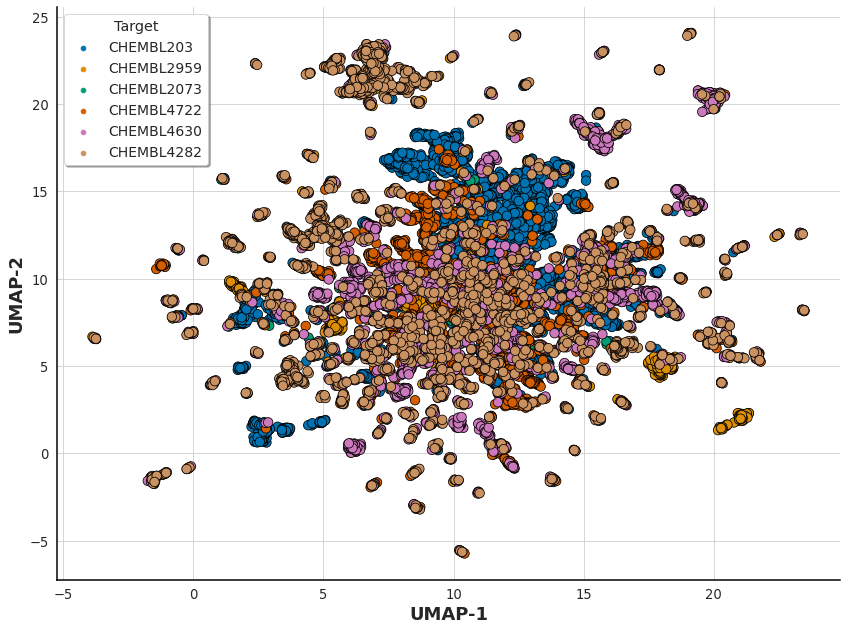

In [108]:
plt.figure(figsize=(12,9))
ax=sns.scatterplot(x=0,y=1,edgecolor='k',s=90,data=embeddings,hue='Target',palette='colorblind')


ax.set_xlabel('UMAP-1',fontweight='bold',fontsize=18)
ax.set_ylabel('UMAP-2',fontweight='bold',fontsize=18)
ax.legend(title='Target',ncol=1,fontsize=14,frameon=True,shadow=True)

sns.despine(left=False, right=True, top=True)

for i in ax.spines.items():
    i[1].set_linewidth(1.5)
    i[1].set_color('k')
plt.tight_layout()

plt.savefig(f'Analysis/scatterplot_umap_all_targets.png',dpi=600)

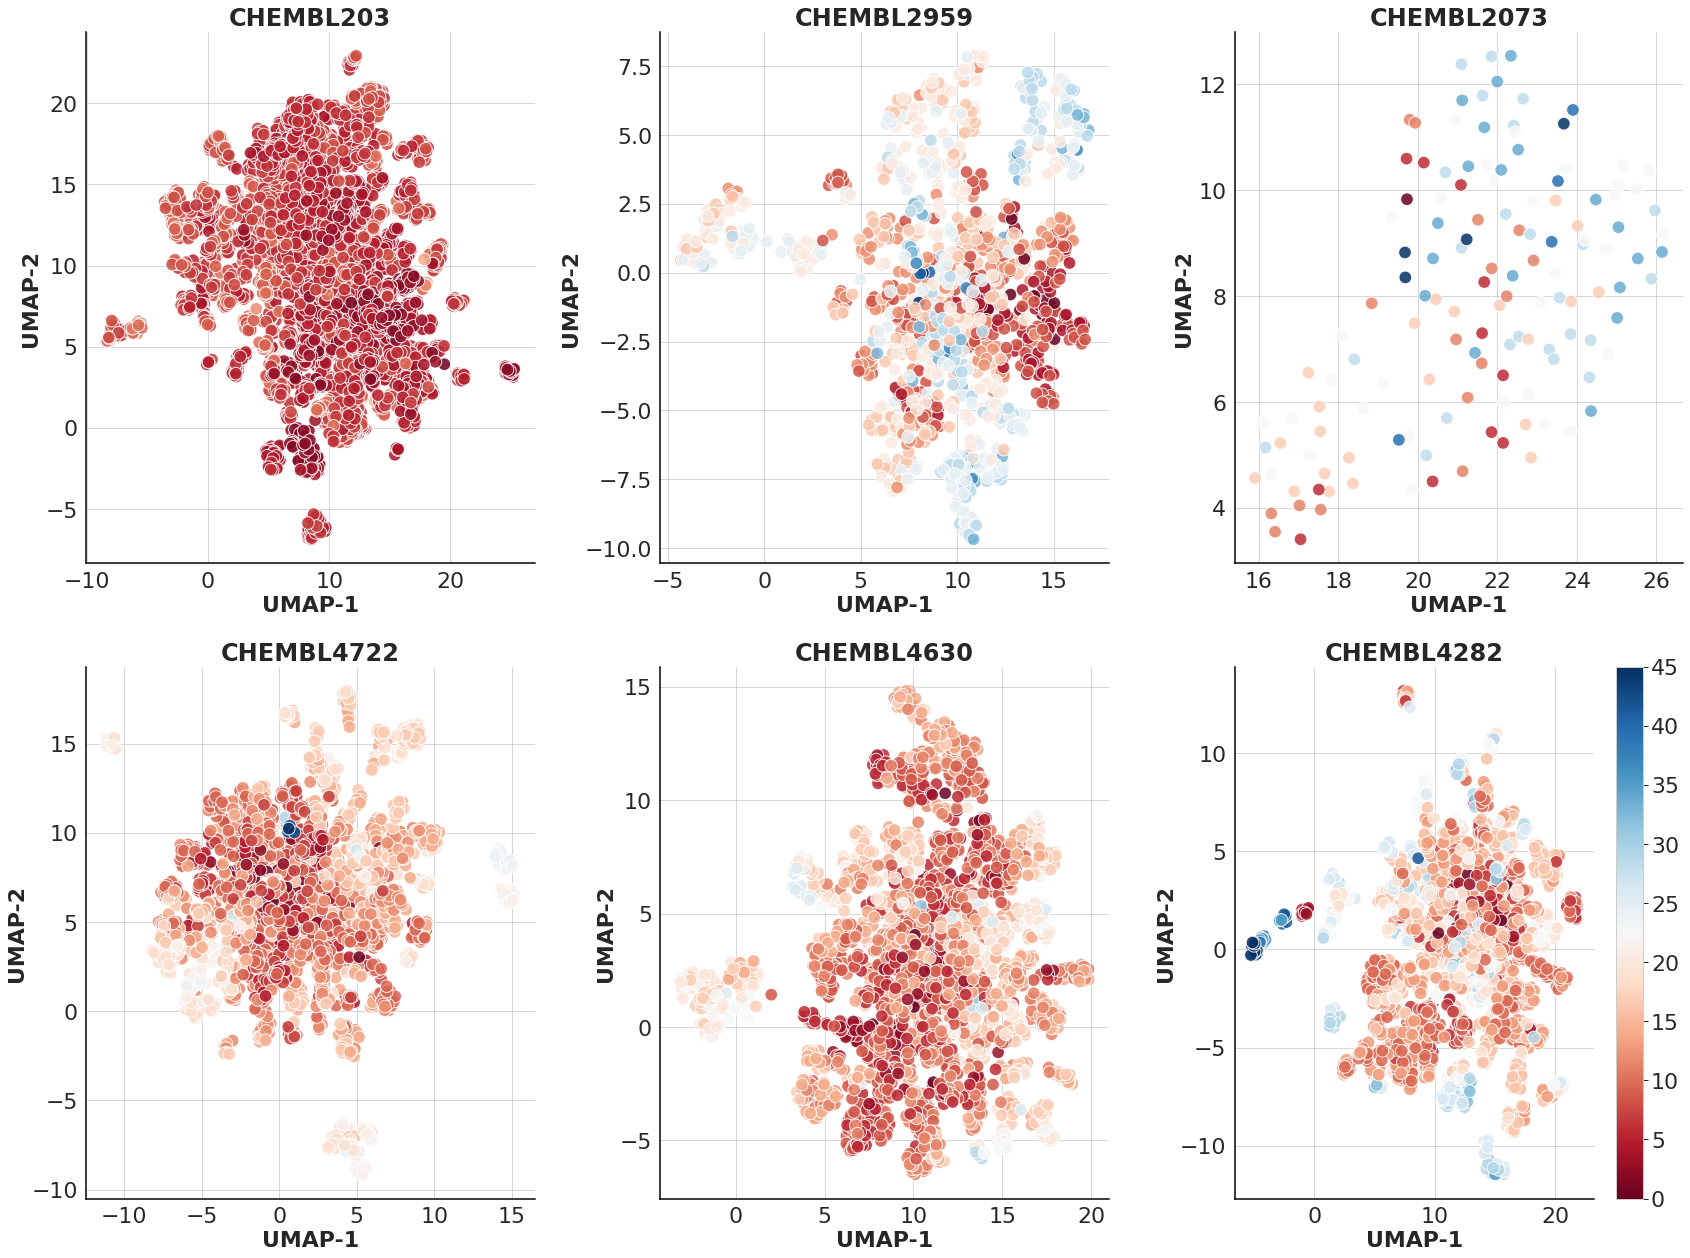

In [34]:
fig, ax = plt.subplots(2,3,figsize=(24,18))

#fig.subplots_adjust(left=0.15,bottom=0.05)
prop = props[4]

ax = ax.ravel()
cmap = plt.get_cmap('tab10').colors
for target_id, target in enumerate(dfs.Target.unique()):
    sns.scatterplot(x=embeddings[target_id][:, 0],
                    y=embeddings[target_id][:, 1],
                    edgecolors='black',s=160,
                    ax=ax[target_id],alpha=0.85,
                    hue=dfs[dfs['Target']==target][prop].values,
                    palette='RdBu',
                    legend=False)



    
    ax[target_id].set_xlabel('UMAP-1',fontweight='bold',fontsize=22)
    ax[target_id].set_ylabel('UMAP-2',fontweight='bold',fontsize=22)

    ax[target_id].set_title(target,fontweight='bold',fontsize=24)

    sns.despine(left=False, right=True, top=True)

    for i in ax[target_id].spines.items():
        i[1].set_linewidth(1.5)
        i[1].set_color('k')
plt.tight_layout()
norm = plt.Normalize(datasets[prop].min(), 
                     datasets[prop].max())

sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])
fig.colorbar(sm)

#plt.savefig(f'Analysis/scatterplot_umap_x_{prop}.png',dpi=600)